##Fine tuning roberta academic


In [ ]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes


import json
import torch
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from huggingface_hub import HfFolder, notebook_login

! pip install transformers[torch] -U
! pip install accelerate -U


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
  Using cached transformers-4.40.0-py3-none-any.whl (9.0 MB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached accelerate-0.29.3-py3-none-any.whl (297 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.

ERROR: Operation cancelled by user


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import  argparse
import pandas as pd
import json
import numpy as np


In [ ]:
with open("/content/drive/MyDrive/Marcus_Project/arxiv_chatGPT_train.jsonl", "r") as file:
    train_data = [json.loads(line) for line in file]

with open("/content/drive/MyDrive/Marcus_Project/arxiv_chatGPT_validation.jsonl", "r") as file:
    val_data = [json.loads(line) for line in file]


In [ ]:
# Create a list to store examples and labels
train_examples = []
train_labels = []

# Iterate through each line in the data
for example in train_data:
    # Append the human-generated text and assign label 0
    train_examples.append(example["human_text"])
    train_labels.append(0)
    # Append the machine-generated text and assign label 1
    train_examples.append(example["machine_text"])
    train_labels.append(1)


In [ ]:
# Create a list to store examples and labels
val_examples = []
val_labels = []

# Iterate through each line in the data
for example in train_data:
    # Append the human-generated text and assign label 0
    val_examples.append(example["human_text"])
    val_labels.append(0)
    # Append the machine-generated text and assign label 1
    val_examples.append(example["machine_text"])
    val_labels.append(1)


In [ ]:
from datasets import Dataset
# Create a Dataset object with the text and corresponding labels
train_dataset = Dataset.from_dict({"text": train_examples, "labels": train_labels})
val_dataset = Dataset.from_dict({"text": val_examples, "labels": val_labels})


In [ ]:
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig
)
from sklearn.metrics import accuracy_score


In [ ]:
# Load the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("andreas122001/roberta-academic-detector")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


In [ ]:
train_data = train_dataset.map(tokenize_function, batched=True)
val_data = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

In [ ]:
model_id = "roberta-base"
dataset_id = "ag_news"
# relace the value with your model: ex <hugging-face-user>/<model-name>
repository_id = "egumasa/roberta-base-academic"


In [ ]:
notebook_login()


In [ ]:
# Define the model
model = RobertaForSequenceClassification.from_pretrained("andreas122001/roberta-academic-detector", num_labels=2)


config.json:   0%|          | 0.00/885 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)


In [ ]:
# Fine-tune the model
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000


TrainOutput(global_step=1440, training_loss=8.499965612192757e-06, metrics={'train_runtime': 1513.5481, 'train_samples_per_second': 7.611, 'train_steps_per_second': 0.951, 'total_flos': 3031039357747200.0, 'train_loss': 8.499965612192757e-06, 'epoch': 3.0})

##Saving the model

In [ ]:
import os

# Define the directory in Google Drive where you want to save the model
output_dir = "/content/drive/MyDrive/Marcus_Project/roberta_academic_finetuned"

# Make sure the directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model and tokenizer
model_path = os.path.join(output_dir, "model")
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


trainer.model.config.save_pretrained(model_path)


In [ ]:
from transformers import pipeline

# Load the tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Marcus_Project/roberta_academic_finetuned/model")
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Marcus_Project/roberta_academic_finetuned/model")
classifier = pipeline('text-classification',"/content/drive/MyDrive/Marcus_Project/roberta_academic_finetuned/model")


## Test =  machine_generated abstracts


In [ ]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/arxiv_chatGPT_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count)
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human_text')

print(true_labels)

['machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated', 'human_text', 'machine-generated'

The accuracy is 0.7616666666666667
The precision is 0.8358576134856459
The recall is 0.7616666666666667


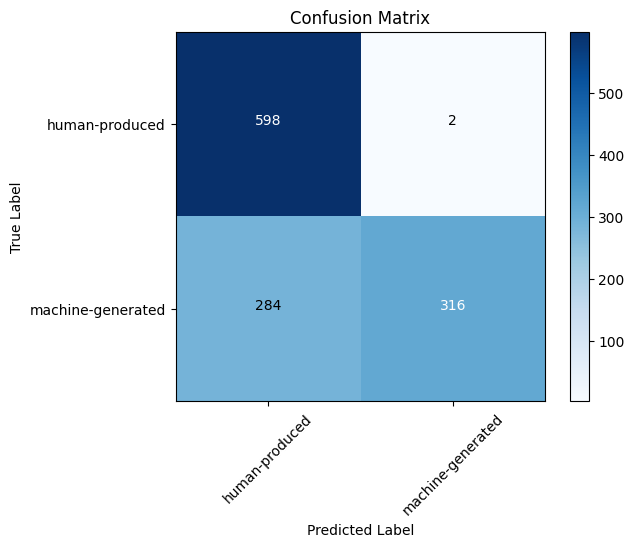

In [ ]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing 50 paraphrased

In [ ]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/arxiv_chatGPT_paraphrased_mt_full.jsonl"



# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count)
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the first 50 entries
results = classify_texts(jsonl_path)
print(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print(len(results))

The accuracy is 0.7583333333333333
The precision is 0.8356722106722108
The recall is 0.7583333333333333


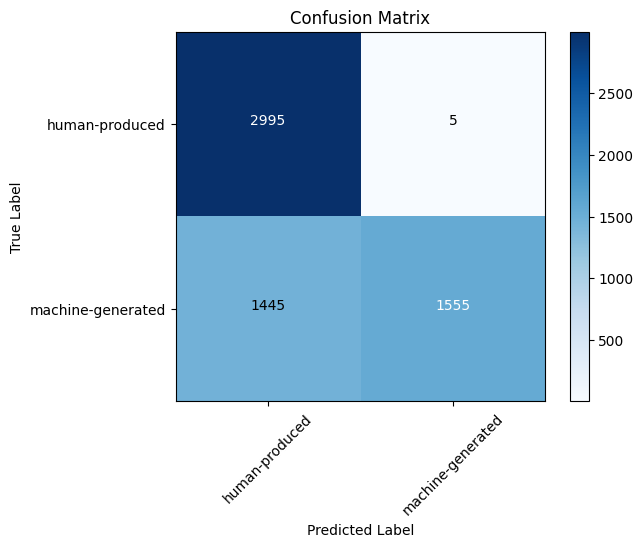

In [ ]:
true_labels = []
for i in range(0, 3000):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing cohere dataset


In [ ]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/arxiv_cohere_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count)
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

The accuracy is 0.5391666666666667
The precision is 0.7406184405877234
The recall is 0.5391666666666667


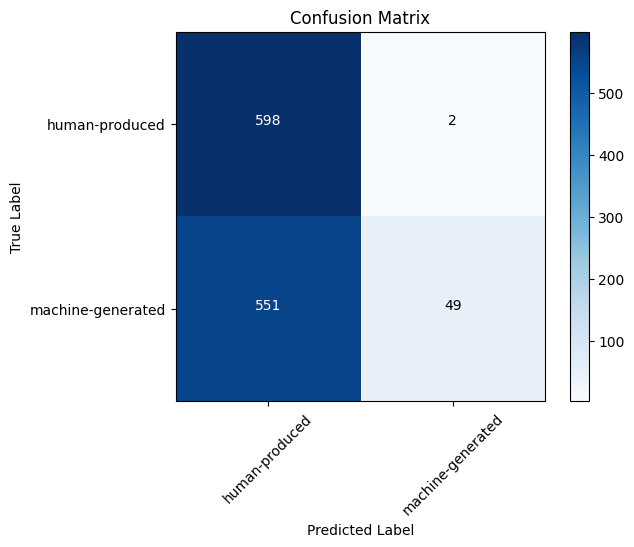

In [ ]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing Davinci Dataset

In [ ]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/arxiv_davinci_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count)
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

The accuracy is 0.5341666666666667
The precision is 0.747231211432936
The recall is 0.5341666666666667


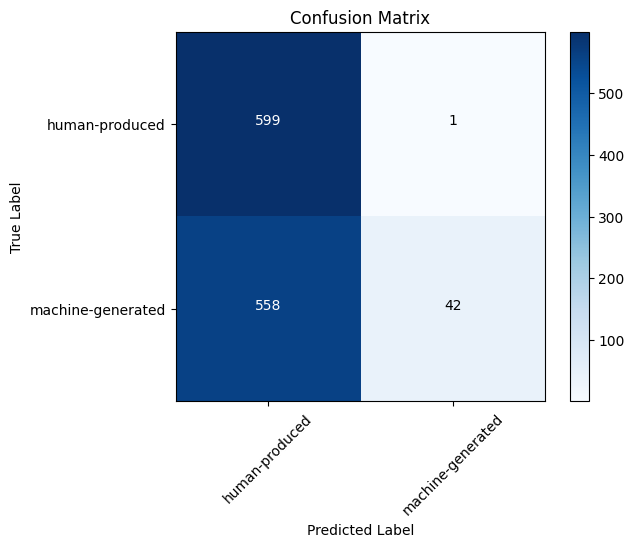

In [ ]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing flant5 dataset

In [ ]:
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/arxiv_flant5_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_text']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['human_text']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count)
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

The accuracy is 0.8366666666666667
The precision is 0.8750742721330957
The recall is 0.8366666666666667


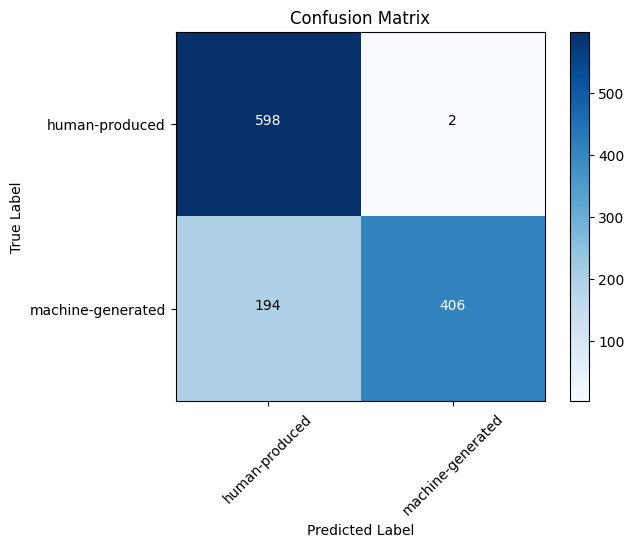

In [ ]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()



##Testing Bloomz dataset

In [ ]:
import json
# Path to the JSONL file
jsonl_path = "/content/drive/MyDrive/Marcus_Project/arxiv_bloomz_test.jsonl"

# Function to truncate or split machine_text to fit within max_length
def truncate_or_split(text, max_length=512):
    if len(text) <= max_length:
        return [text]
    else:
        # Truncate the text to max_length
        return [text[:max_length]]

# Function to read JSONL file and classify texts
def classify_texts(jsonl_path):
    predictions = []
    line_count = 0
    count = 0
    with open(jsonl_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            machine_text = data['machine_abstract']

            # Truncate or split machine_text to fit within max_length
            machine_text_segments = truncate_or_split(machine_text)

            for segment in machine_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            human_text = data['abstract']

            # Truncate or split machine_text to fit within max_length
            human_text_segments = truncate_or_split(human_text)

            for segment in human_text_segments:
                # Classify each segment of machine_text
                result = classifier(segment)
                # Append the most confident prediction
                predictions.append(result[0]['label'])

            line_count += 1
            print(count)
            #print(predictions)
            count += 1
    return predictions

# Get predictions for the entries in the JSONL file
results = classify_texts(jsonl_path)
print(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

The accuracy is 0.5283333333333333
The precision is 0.7309991847087598
The recall is 0.5283333333333333


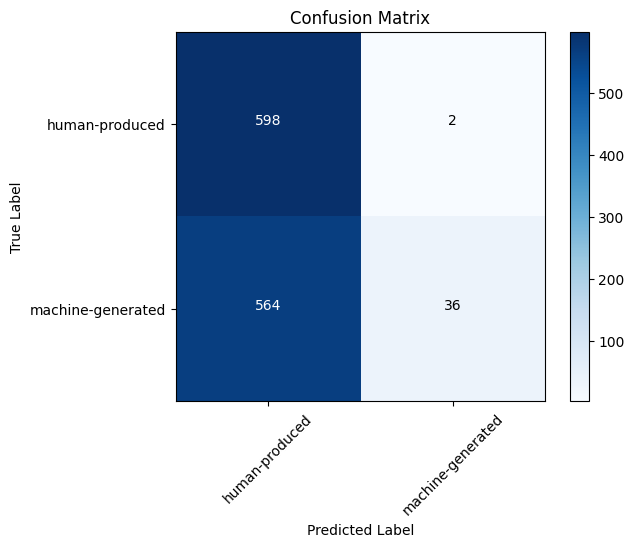

In [ ]:
true_labels = []
for i in range(0, 600):
    true_labels.append('machine-generated')
    true_labels.append('human-produced')


# Count occurrences of each label
human_count = results.count('human-produced')
machine_count = results.count('machine-generated')

# Calculate total number of predictions
total_predictions = len(results)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
# Fit encoder with all possible labels
all_labels = ['human-produced', 'machine-generated']
encoder.fit(all_labels)
true_labels_encoded = encoder.fit_transform(true_labels)
predictions_encoded = encoder.transform(results)


# Compute confusion matrix
cm = confusion_matrix(true_labels_encoded, predictions_encoded)

# Compute accuracy
accuracy = accuracy_score(true_labels_encoded, predictions_encoded)
print('The accuracy is', accuracy)
# Compute precision
precision = precision_score(true_labels_encoded, predictions_encoded, average='macro')
print('The precision is', precision)
# Compute recall
recall = recall_score(true_labels_encoded, predictions_encoded, average='macro')
print('The recall is', recall)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.show()

